In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, classification_report, log_loss
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay, auc, roc_curve

## Combine

In [2]:
target_names = ["REAL", "FAKE"]


Random_2D_Path = r"predictions\scores_efficient_net4_dropoutrandom.csv"
results_path = r"predictions/final_efficient_net4.csv"
results_3D_cloud = r"predictions/scores_efficient_net4_3D_cloud.csv"

ground_truth_path = r"../../data/test/labels.csv"
ground_truth = pd.read_csv(ground_truth_path)
truth_labels = ground_truth["label"].values

predicted_labels_3D = pd.read_csv(results_3D_cloud).prediction.values
predicted_labels_2D = pd.read_csv(results_path).label.values
predicted_labels_2D_DropRandom = pd.read_csv(Random_2D_Path).label.values

In [3]:
combined_labels = (predicted_labels_2D + predicted_labels_3D + predicted_labels_2D_DropRandom) / 3

In [4]:
combined_labels

array([0.99000009, 0.9897513 , 0.98701743, ..., 0.01649987, 0.94668355,
       0.99000005])

In [5]:
loss_combined = log_loss(truth_labels, combined_labels)
# This is very good result
loss_combined

0.29882826481055486

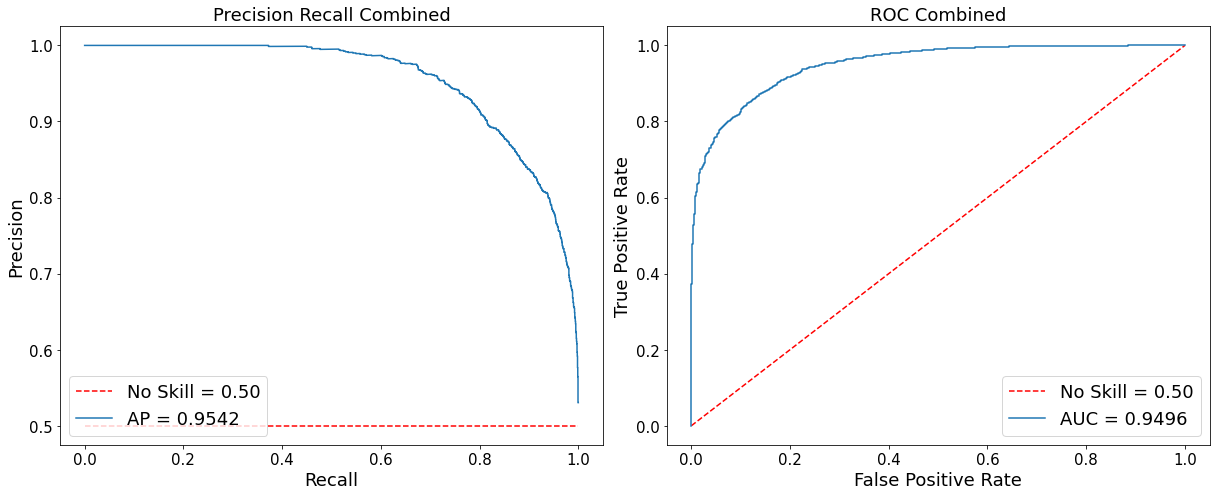

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))

# Precision Recall
average_precision = average_precision_score(truth_labels, combined_labels)
precision, recall, threshold_precision = precision_recall_curve(truth_labels, combined_labels)
no_skill = 0.5
ax1.set_title("Precision Recall Combined", fontsize=18)
ax1.plot([0, 1], [no_skill, no_skill], 'r--', linestyle='--', label='No Skill = %0.2f' % 0.5)
ax1.plot(recall, precision, label = 'AP = %0.4f' % average_precision)
ax1.legend(loc = 'lower left', prop={'size': 18})
ax1.set_ylabel('Precision', fontsize=18)
ax1.set_xlabel('Recall', fontsize=18)
ax1.tick_params(axis="x", labelsize=15)
ax1.tick_params(axis="y", labelsize=15)

# ROC
fpr, tpr, threshold_auc = roc_curve(truth_labels, combined_labels)
roc_auc = auc(fpr, tpr)
ax2.set_title('ROC Combined', fontsize=18)
ax2.plot([0, 1], [0, 1],'r--', label='No Skill = %0.2f' % 0.5)
ax2.plot(fpr, tpr, label = 'AUC = %0.4f' % roc_auc)
ax2.legend(loc = 'lower right', prop={'size': 18})
ax2.set_ylabel('True Positive Rate', fontsize=18)
ax2.set_xlabel('False Positive Rate', fontsize=18)
ax2.tick_params(axis="x", labelsize=15)
ax2.tick_params(axis="y", labelsize=15)

fig.tight_layout()

In [7]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold_auc[optimal_idx]
optimal_threshold

0.415995707

In [8]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
optimal_f_threshold = threshold_precision[ix]
optimal_f_threshold

0.33107822233333334

In [9]:
# change to zeros and 1s
for i in range(len(combined_labels)):
    if combined_labels[i] > optimal_threshold:
        combined_labels[i] = 1
    else:
        combined_labels[i] = 0

In [10]:
cm = confusion_matrix(truth_labels, combined_labels)

<AxesSubplot:>

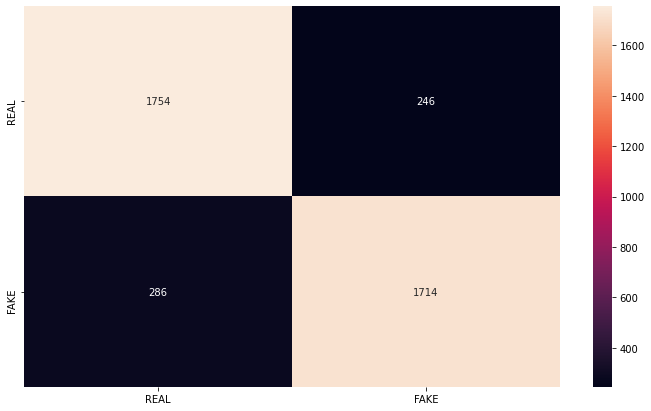

In [11]:
df_cm = pd.DataFrame(cm, index = target_names,
                  columns = target_names)
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, fmt='d')

In [12]:
print("Classification report for deepfake classifier:\n%s\n"
      % (classification_report(truth_labels, combined_labels, target_names=target_names)))

Classification report for deepfake classifier:
              precision    recall  f1-score   support

        REAL       0.86      0.88      0.87      2000
        FAKE       0.87      0.86      0.87      2000

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000


